In [3]:
%matplotlib inline


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
from numba import njit

from glob import glob

from xhistogram.xarray import histogram


import julian
import datetime
import cftime

import warnings
warnings.filterwarnings('ignore')

### dictionary containing waypoints for all cross-sections to run the script on:

In [4]:
sections_dict = {
                 'lat' : {'OSNAPW' : tuple([52.0166, 52.6648, 53.5577, 58.8944, 60.4000]),
                          'OSNAPE' : tuple([60.3000, 58.8600, 58.0500, 58.0000, 56.5000])                          
                          },
                 'lon' : {'OSNAPW' : tuple([-56.8775, -52.0956, -49.8604, -47.6107, -44.8000]),
                          'OSNAPE' : tuple([-44.9000, -30.5400, -28.0000, -14.7000, -5.9300])
                          }
                 }

## Dictionary containing all input variables for each model simulation to run the scripts on:

In [26]:
### Dictionary of inputs needed to load the different CM4 runs
run_dict = {
                ## 'odiv209' : {
                ##              'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                ##              'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/",
                ##              'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                ##              'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ocean_annual_z_d2.static.nc",                    
                ##              'file_str_identifier' : "*",
                ##              'z_layer_var' : "rho0_l",
                ##              'z_inter_var' : "rho0_i",
                ##              'color_identifier' : 'b',
                ##              'legend_label' : "1/8 deg control",
                ##              },
                'odiv230' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",                 
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'yellow',
                             'legend_label' : "1/4 deg control",
                             },
                'odiv231' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",                             
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'y',
                             'legend_label' : "1/4 deg historical",
                             },
              'odiv232' :   {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",                    
                             'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",                             
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'm',
                             'legend_label' : "1/4 deg ssp585",
                             },
                'odiv233' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ocean_annual_z_d2.static.nc",
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'fuchsia',
                             'legend_label' : "1/8 deg historical",
                             },
#                'odiv209' : {
#                             'dir_vars' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
#                             'dir_eddy_vars' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/",
#                             'dir_grid' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
#                             'dir_grid_eddy' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z_d2/ocean_annual_z_d2.static.nc",
#                             'file_str_identifier' : "*",
#                             'lat_range' : [26.3], ### Note that I have chosen 26.3 because this is where the _d2 grid matches the regular grid
#                             'basin_list': [2],
#                             'z_layer_var' : "z_l",
#                             'z_inter_var' : "z_i",
#                             'color_identifier' : 'b',
#                             'legend_label' : '1/8 deg control',
#                             },
                'odiv306' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel22-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel22-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel22-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel22-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
                             # 'file_str_identifier' : "*.0231*",
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'yellow',
                             'legend_label' : '1/4 deg control',
                             },
                'odiv313' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path': "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z_d2/ocean_annual_z_d2.static.nc",
                             # 'file_str_identifier' : "*.0231*",
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'green',
                             'legend_label' : '1/4 deg control',
                             },
#                'odiv1' :   {
#                             'dir_vars' : "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/",
#                             'dir_eddy_vars' : "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/",
#                             'dir_grid' : "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
#                             'dir_grid_eddy' : "/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
#                             'file_str_identifier' : "*",
#                             'lat_range' : [26.3],
#                             'basin_list': [2],
#                             'z_layer_var' : "z_l",
#                             'z_inter_var' : "z_i",
#                             'legend_label' : "1/4 deg CMIP control",
#                             'color_identifier' : 'pink',
#                             },
#                'odiv210' : {
#                             'dir_vars' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
#                             'dir_eddy_vars' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
#                             'dir_grid' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
#                             'dir_grid_eddy' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
#                             'file_str_identifier' : "*",
#                             'lat_range' : [26.3], ### Note that I have chosen 26.3 because this is where the _d2 grid matches the regular grid
#                             'basin_list': [2],
#                             'z_layer_var' : "z_l",
#                             'z_inter_var' : "z_i",
#                             'color_identifier' : 'r',
#                             'legend_label' : '1/4 deg pre-control',
#                             },
           }

In [20]:
run_dict = {
 
     'odiv231aodiv232bc_2014_2020' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path' : "/archive/Bill.Hurlin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",                             
                             'file_str_identifier' : "*2020*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'red',
                             'line_width' : '3',
                             'line_style' : '-',
                             'legend_label' : "CM4X-p25",
                             },
      'odiv255aodiv293bc_2014_2020' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_ssp585_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_ssp585_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_ssp585_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z_d2/ts/annual/5yr/",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_ssp585_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z_d2/ocean_annual_z_d2.static.nc",
                             'file_str_identifier' : "*2020*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'green',
                             'line_width' : '4',
                             'line_style' : '--',
                             'legend_label' : "CM4X-p125"
                             },
            }

In [7]:
RDC_dict={
                'RDC_p25' : {
                             'vars_path' : "/archive/roz/cm2.hi/CM2.hi_Control_1990_E01_rs_wind_cars_woa_newtopog/gfdl.ncrc3-intel15-prod/pp/ocean/ts/annual/20yr/",
                             'grid_path' : "/archive/roz/cm2.hi/CM2.hi_Control_1990_E01_rs_wind_cars_woa_newtopog/gfdl.ncrc3-intel15-prod/pp/ocean/ocean.static.nc",
                             'file_str_identifier' : "*.0061*",
                             'mom_gridwidth_algo' : False,
                             'z_layer_var' : "potrho",
                             'z_inter_var' : "potrho_edges",
                             'u_transport_var' : "tx_trans_rho",
                             'v_transport_var' : "ty_trans_rho",
                             'x_hpoint_1Dvar' : "grid_xt_ocean",
                             'x_qpoint_1Dvar' : "grid_xu_ocean",
                             'y_hpoint_1Dvar' : "grid_yt_ocean",
                             'y_qpoint_1Dvar' : "grid_yu_ocean",
                             'grid_x_hpoint_1Dvar' : "xt_ocean",
                             'grid_x_qpoint_1Dvar' : "xu_ocean",
                             'grid_y_hpoint_1Dvar' : "yt_ocean",
                             'grid_y_qpoint_1Dvar' : "yu_ocean",
                             'lons_tpoint' : "geolon_t",
                             'lats_tpoint' : "geolat_t",
                             'lons_cpoint' : "geolon_c",
                             'lats_cpoint' : "geolat_c",
                             'color_identifier' : 'k',
                             'legend_label' : "RDC",
                             }
        }

In [5]:
plt.rcParams.update({"font.size":12})
figsize=[6.5,4.0]
savefig_kws=dict(bbox_inches="tight", facecolor="white", dpi=400, format='jpeg')
degC= "$^{\circ}$C"

In [6]:
# Use the same font as JAMES
dirstix = "/net2/rnd/dev/stixfonts/fonts/static_ttf"
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

# Now read the processed .nc files and compare models with obs and RDC, at each section:

0
1


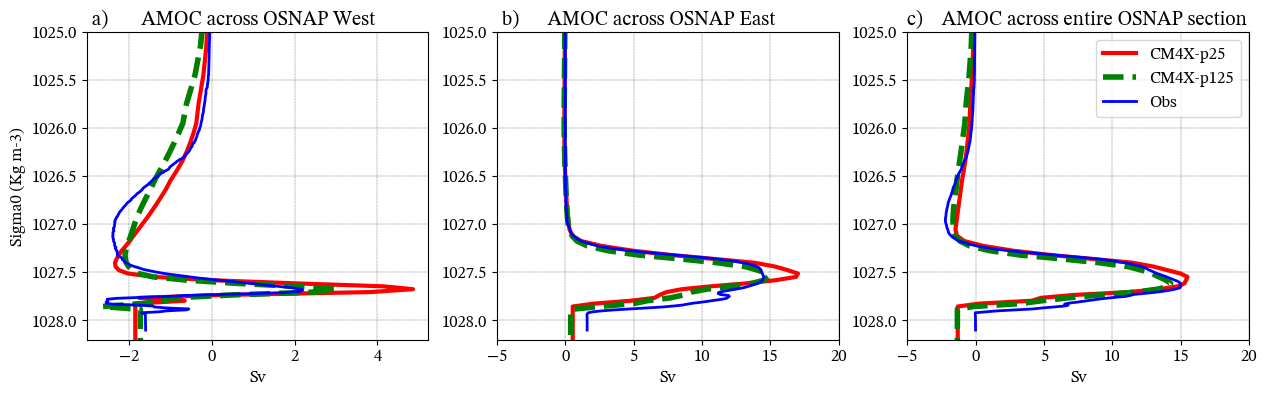

In [21]:
### First plot the OSNAPW and OSNAPE streamfunctions for the models and the RDC
use_RDC_data_flag=0

fig = plt.figure(figsize=(15,4))
#fig = plt.figure(figsize=(15,8))
#control_runs=['odiv231aodiv232bc]  # You can add more models to this list e.g. control_runs=['odiv209','odiv230'] 

section_loopnum=0

section_tot=0
for section in sections_dict['lat']:
    key_loopnum=0
#    for keys in control_runs:
    print (section_loopnum)
    for keys in run_dict:       
        dsT_online=xr.open_dataset("dsT_online_"+keys+"_"+section+".nc")
        MOC_mean=dsT_online.uvnormal.mean(dim='time').sum(dim='sect',skipna=True).cumsum(dim=run_dict[keys]['z_layer_var'])/1035/1e6 
        
        plt.subplot(1,len(sections_dict['lat'])+1,section_loopnum+1)
        MOC_mean.plot(y='rho0_l',ylim=[1028.2,1025],color=run_dict[keys]['color_identifier'],label=run_dict[keys]['legend_label'],ls=run_dict[keys]['line_style'],linewidth=run_dict[keys]['line_width'])       
        key_loopnum+=1
#    
    key_loopnum=0
    if use_RDC_data_flag:
        legend_labels=['RDC']
        for keys in RDC_dict:
#        
            RDC_dsT_online=xr.open_dataset("dsT_online_"+keys+"_"+section+".nc")
            MOC_mean=RDC_dsT_online.uvnormal.mean(dim='time').sum(dim='sect',skipna=True).cumsum(dim=RDC_dict[keys]['z_layer_var'])/1035/1e6 
            section_tot+=MOC_mean      
            plt.subplot(1,len(sections_dict['lat'])+1,section_loopnum+1)
            (MOC_mean*1e6*1035).plot(y='potrho',ylim=[1028.2,1025],color=RDC_dict[keys]['color_identifier'],label=RDC_dict[keys]['legend_label'])
        key_loopnum+=1
    section_loopnum+=1
    
##########
## Now plot the total OSNAP section for the models and the RDC

key_loopnum=0
#for keys in control_runs:
for keys in run_dict:
    section_tot=0
    for section in sections_dict['lat']:
    
        dsT_online=xr.open_dataset("dsT_online_"+keys+"_"+section+".nc")
        MOC_mean=dsT_online.uvnormal.mean(dim='time').sum(dim='sect',skipna=True).cumsum(dim=run_dict[keys]['z_layer_var'])/1035/1e6 
        section_tot+=MOC_mean

    plt.subplot(1,len(sections_dict['lat'])+1,3)
    section_tot.plot(y='rho0_l',ylim=[1028.2,1025],color=run_dict[keys]['color_identifier'],label=run_dict[keys]['legend_label'],ls=run_dict[keys]['line_style'],linewidth=run_dict[keys]['line_width'])
    key_loopnum+=1
    
key_loopnum=0
if use_RDC_data_flag:
    RDC_section_tot=0
    for keys in RDC_dict:
         for section in sections_dict['lat']:
        
            RDC_dsT_online=xr.open_dataset("dsT_online_"+keys+"_"+section+".nc")
            MOC_mean=RDC_dsT_online.uvnormal.mean(dim='time').sum(dim='sect',skipna=True).cumsum(dim=RDC_dict[keys]['z_layer_var'])/1035/1e6 
            RDC_section_tot+=MOC_mean*1e6*1035
    plt.subplot(1,len(sections_dict['lat'])+1,3)
    RDC_section_tot.plot(y='potrho',ylim=[1028.2,1025],color=RDC_dict[keys]['color_identifier'],label=RDC_dict[keys]['legend_label'])
    key_loopnum+=1
    
###########
### Now add on the observations

ds_OSNAP_streamfunction=xr.open_dataset("ds_OSNAP_streamfunction.nc")
plt.subplot(1,len(sections_dict['lat'])+1,1)
ds_OSNAP_streamfunction.T_WEST.mean('TIME').plot(y='LEVEL',label='Obs',color='blue',linewidth=2)
plt.title(' a)       AMOC across OSNAP West',loc='left')
plt.xlabel('Sv')
plt.ylabel('Sigma0 (Kg m-3)')
plt.grid(color='black', linestyle='--', linewidth=.2)
plt.subplot(1,len(sections_dict['lat'])+1,2)
ds_OSNAP_streamfunction.T_EAST.mean('TIME').plot(y='LEVEL',label='Obs',color='blue',linewidth=2)
plt.title(' b)      AMOC across OSNAP East', loc='left')
plt.xlabel('Sv')
plt.ylabel('')
plt.xlim(-5.,20.)
plt.grid(color='black', linestyle='--', linewidth=.2)
plt.subplot(1,len(sections_dict['lat'])+1,3)
ds_OSNAP_streamfunction.T_ALL.mean('TIME').plot(y='LEVEL',label='Obs',color='blue',linewidth=2)
plt.title('c)    AMOC across entire OSNAP section',loc='left')
plt.xlabel('Sv')
plt.ylabel('')
plt.xlim(-5.,20.)
plt.grid(color='black', linestyle='--', linewidth=.2)
plt.legend()
#plt.savefig('Fig_26_AMOC_RAPID_Control_Time_Series_5_9_25.jpeg',**savefig_kws)

In [7]:
run_dict = {
         'odiv230odiv306' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",                 
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc",
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'r',
                             'line_width' : '3',
                             'line_style' : '-',
                             'legend_label' : "CM4X-p25",
                             },
         'odiv313odiv437' : {
                             'vars_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_rho0/ts/monthly/5yr/",
                             'heat_vars_path': "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z_d2/ts/annual/10yr/",
                             'grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_month_rho0/ocean_month_rho0.static.nc",
                             'heat_grid_path' : "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_piControl_c192_OM4p125_v8/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual_z_d2/ocean_annual_z_d2.static.nc",
                             # 'file_str_identifier' : "*.0231*",
                             'file_str_identifier' : "*",
                             'z_layer_var' : "rho0_l",
                             'z_inter_var' : "rho0_i",
                             'color_identifier' : 'green',
                             'line_width' : '5',
                             'line_style' : '--',
                             'legend_label' : 'CM4X-p125',
                             },
          }

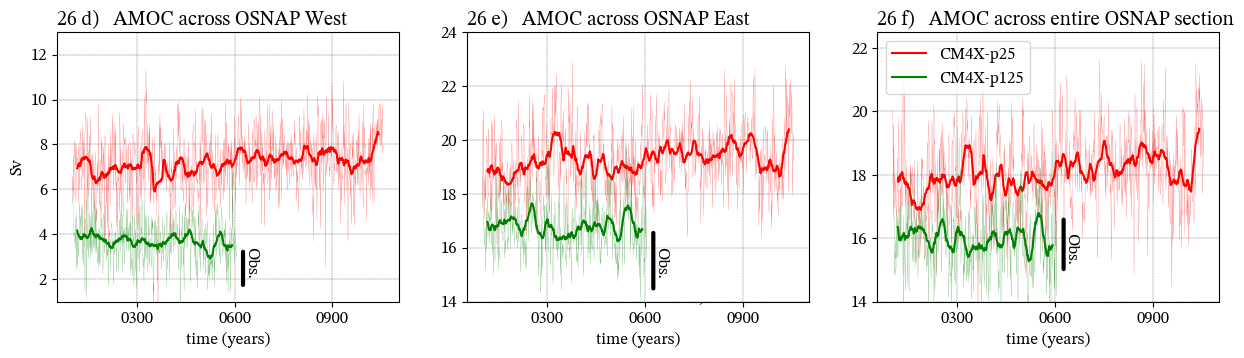

In [19]:
### Now plot the OSNAPW and OSNAPE timeseries for the models

control_runs=['odiv230odiv306','odiv313odiv437'] # You can add more models to this list e.g. control_runs=['odiv209','odiv230'] 
annotation_timedelta=20  # In years. Can be changed to modify where the line will sit at the right-hand-side, showing the observational range
smoothing_level=30 # In years. Smoothing level of the smoothed thick line

fig = plt.figure(figsize=(15,3.5))
start_dates=[]
end_dates=[]
loopnum=0
for section in sections_dict['lat']:
    for keys in control_runs:
#   for keys in run_dict:        
        dsT_online=xr.open_dataset("dsT_online_"+keys+"_"+section+".nc")      
        MOC_rho=dsT_online.uvnormal.sum(dim='sect',skipna=True).cumsum(dim=run_dict[keys]['z_layer_var'])/1030/1e6   
        MOC_ts=MOC_rho.resample(time="Y").mean().where(MOC_rho[run_dict[keys]['z_layer_var']]>1025).max(dim=run_dict[keys]['z_layer_var'])
        MOC_ts = xr.open_dataarray("MOC_ts_"+keys+"_"+section+".nc") 
        plt.subplot(1,len(sections_dict['lat'])+1,loopnum+1)
        MOC_ts.plot(color=run_dict[keys]['color_identifier'],linewidth=.1)
        MOC_ts.rolling(time=smoothing_level,center=True).mean().plot(color=run_dict[keys]['color_identifier'],label=run_dict[keys]['legend_label'])

        start_dates.append(MOC_ts.time.values[0])
        end_dates.append(MOC_ts.time.values[504])
#      
    loopnum+=1
    
#####
## Now plot the total OSNAP section for the models 

key_loopnum=0
for keys in control_runs:
    section_tot_sf=0
    for section in sections_dict['lat']:
    
        dsT_online=xr.open_dataset("dsT_online_"+keys+"_"+section+".nc")

        MOC_rho=dsT_online.uvnormal.sum(dim='sect',skipna=True).cumsum(dim=run_dict[keys]['z_layer_var'])/1035/1e6 
        section_tot_sf+=MOC_rho
    
    MOC_ts=section_tot_sf.resample(time="Y").mean().where(section_tot_sf[run_dict[keys]['z_layer_var']]>1025).max(dim=run_dict[keys]['z_layer_var']) 
    MOC_ts=xr.open_dataarray("MOC_ts_section_tot_"+keys+"_"+section+".nc")
    plt.subplot(1,len(sections_dict['lat'])+1,3)
    MOC_ts.plot(color=run_dict[keys]['color_identifier'],linewidth=.1)
    MOC_ts.rolling(time=smoothing_level,center=True).mean().plot(color=run_dict[keys]['color_identifier'],label=run_dict[keys]['legend_label'])
    key_loopnum+=1


#######
### Now add on the observational range as a bar at the side

ds_OSNAP_streamfunction=xr.open_dataset("/home/Bill.Hurlin/Matthew.Thomas/python_code/python_scripts/CM4hires_figures/AMOCsig0_OSNAP_online_data/ds_OSNAP_streamfunction.nc")
outside_fig_date=np.max(end_dates)+datetime.timedelta(weeks = 52*annotation_timedelta) 
plt.subplot(1,len(sections_dict['lat'])+1,1)
obs_MOC_west_ts=ds_OSNAP_streamfunction.T_WEST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').rolling(TIME=12).mean()
# plt.fill_between([np.min(start_dates),np.max(end_dates)],ds_OSNAP_streamfunction.T_WEST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').mean()-ds_OSNAP_streamfunction.T_WEST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').std(),ds_OSNAP_streamfunction.T_WEST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').mean()+ds_OSNAP_streamfunction.T_WEST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').std(), alpha=0.2, label='obs (mean+/-std)')
plt.annotate('',xy=(outside_fig_date,obs_MOC_west_ts.mean()-obs_MOC_west_ts.std()),xytext=(outside_fig_date,obs_MOC_west_ts.mean()+obs_MOC_west_ts.std()),arrowprops=dict(arrowstyle="-",color='k',linewidth=3),annotation_clip=False)
text=plt.annotate('Obs.',xy=(outside_fig_date,-.3+obs_MOC_west_ts.mean()), xytext=(outside_fig_date,-.3+obs_MOC_west_ts.mean()),annotation_clip=False)
text.set_rotation(270)
plt.ylim([1,13])
plt.ylabel('Sv')
plt.xlabel('time (years)')
plt.grid(color='black', linestyle='--', linewidth=.2)
plt.title('26 d)   AMOC across OSNAP West',loc='left')
plt.gca().text(x=0,y=1,s='d)', fontsize=12, color='black') 

plt.subplot(1,len(sections_dict['lat'])+1,2)
obs_MOC_east_ts=ds_OSNAP_streamfunction.T_EAST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').rolling(TIME=12).mean()
# plt.fill_between([np.min(start_dates),np.max(end_dates)],ds_OSNAP_streamfunction.T_EAST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').mean()-ds_OSNAP_streamfunction.T_EAST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').std(),ds_OSNAP_streamfunction.T_EAST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').mean()+ds_OSNAP_streamfunction.T_EAST.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').std(), alpha=0.2, label='obs (mean+/-std)')
plt.annotate('',xy=(outside_fig_date,obs_MOC_east_ts.mean()-obs_MOC_east_ts.std()),xytext=(outside_fig_date,obs_MOC_east_ts.mean()+obs_MOC_east_ts.std()),arrowprops=dict(arrowstyle="-",color='k',linewidth=3),annotation_clip=False)
text=plt.annotate('Obs.',xy=(outside_fig_date,-.5+obs_MOC_east_ts.mean()), xytext=(outside_fig_date,-.5+obs_MOC_east_ts.mean()),annotation_clip=False)
text.set_rotation(270)
plt.ylim([14,24])
plt.ylabel('')
plt.xlabel('time (years)')
plt.grid(color='black', linestyle='--', linewidth=.2)
plt.title('26 e)   AMOC across OSNAP East',loc='left')
#

plt.subplot(1,len(sections_dict['lat'])+1,3)
obs_MOC_tot_ts=ds_OSNAP_streamfunction.T_ALL.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').rolling(TIME=12).mean()
# plt.fill_between([np.min(start_dates),np.max(end_dates)],ds_OSNAP_streamfunction.T_ALL.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').mean()-ds_OSNAP_streamfunction.T_ALL.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').std(),ds_OSNAP_streamfunction.T_ALL.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').mean()+ds_OSNAP_streamfunction.T_ALL.where(ds_OSNAP_streamfunction.LEVEL>1026).max(dim='LEVEL').std(), alpha=0.2, label='obs (mean+/-std)')
plt.annotate('',xy=(outside_fig_date,obs_MOC_tot_ts.mean()-obs_MOC_tot_ts.std()),xytext=(outside_fig_date,obs_MOC_tot_ts.mean()+obs_MOC_tot_ts.std()),arrowprops=dict(arrowstyle="-",color='k',linewidth=3),annotation_clip=False)
text=plt.annotate('Obs.',xy=(outside_fig_date,-.5+obs_MOC_tot_ts.mean()), xytext=(outside_fig_date,-.5+obs_MOC_tot_ts.mean()),annotation_clip=False)
text.set_rotation(270)
plt.ylim([14,22.5])
plt.ylabel('')
plt.xlabel('time (years)')
plt.grid(color='black', linestyle='--', linewidth=.2)
plt.title('26 f)   AMOC across entire OSNAP section',loc='left')
#
plt.legend()

In [ ]:
#end of fig 26 notebook